<a href="https://colab.research.google.com/github/IdealisticINTJ/My_Machine_Learning_Projects/blob/main/COVID_X-Ray_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os, random
import pickle
from imutils import paths

import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
!wget https://www.dropbox.com/s/oo9i9ttn3di0182/Covid_Dataset_2020_07_31.zip?dl=0
!unzip Covid_Dataset_2020_07_31.zip\?dl\=0
print("Data set successfully imported.")

--2021-06-02 10:42:10--  https://www.dropbox.com/s/oo9i9ttn3di0182/Covid_Dataset_2020_07_31.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/oo9i9ttn3di0182/Covid_Dataset_2020_07_31.zip [following]
--2021-06-02 10:42:10--  https://www.dropbox.com/s/raw/oo9i9ttn3di0182/Covid_Dataset_2020_07_31.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44067d1487a91f79b8b64c0045.dl.dropboxusercontent.com/cd/0/inline/BPoAw-bjIDG0O5YUNiPIPiY_gIEK8pYQoy371L-BREK2KHXVg7GA6HweNdRs_9Ppx84BaZnie7Wpl_hT3eHDECSmKukxL9av8fK4ZBA_g8WmLb3hEA7e3txO8a4nnjDo-qEcyKudLFnvGChRjmmePMNP/file# [following]
--2021-06-02 10:42:10--  https://uc44067d1487a91f79b8b64c0045.dl.dropboxusercontent.com/cd/0/inline/BPoAw-bjIDG0O5YUNiPIPiY_gIEK8pYQoy371

In [3]:

path = "./Covid_Dataset/"
filepath = []

for root, directories, files in os.walk(path, topdown=False):
  for name in files:
    filepath.append(os.path.join(root, name))


set = []
diagnosis = []
imgname = []

for i in filepath:
  imgname.append(i.split("/")[4])
  set.append(i.split("/")[2])
  diagnosis.append(i.split("/")[3])

df = pd.DataFrame(list(zip(imgname, set, diagnosis)),
                  columns = ['Filename', 'Set', 'Diagnosis'])

df.to_csv('covid_metadata.csv', index=False)

df.sample(5)

,Filename,Set,Diagnosis
226,all14238-fig-0001-m-b.jpg,Train,Covid
113,NORMAL2-IM-0843-0001.jpeg,Train,Normal
0,NORMAL2-IM-1338-0001.jpeg,Test,Normal
315,441c9cdd.jpg,Train,Covid
176,NORMAL2-IM-0955-0001.jpeg,Train,Normal


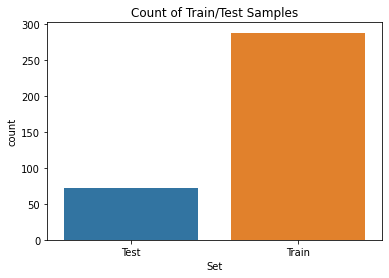

In [4]:
sns.countplot(data=df, x='Set')
plt.title('Count of Train/Test Samples');

In [5]:
normal_images_train = list(paths.list_images(f"./Covid_Dataset/Train/Normal/"))
covid_images_train = list(paths.list_images(f"./Covid_Dataset/Train/Covid/"))

def plots_from_files(imspaths, figsize=(18,9), display_images=25, rows=1, cols=1, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=40)
    
    for i in range(0, display_images):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

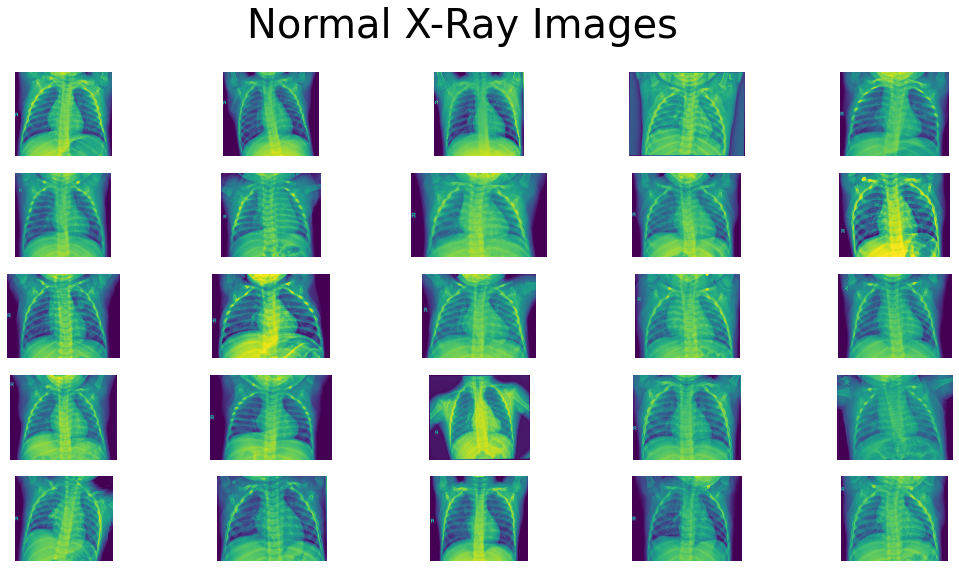

In [6]:
plots_from_files(normal_images_train, rows=5, cols=5, display_images=25, maintitle="Normal X-Ray Images")

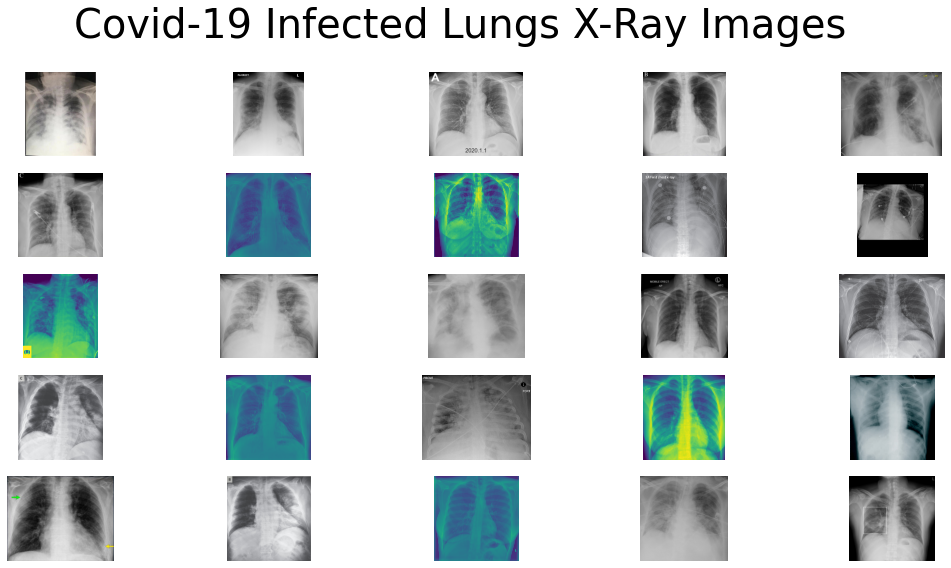

In [7]:
plots_from_files(covid_images_train, rows=5, cols=5, display_images=25, maintitle="Covid-19 Infected Lungs X-Ray Images")

In [8]:
# Building a CNN Based Model in Keras.
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

In [10]:
EPOCHS = 33
BS = 32

In [11]:
train_data = image.ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [12]:
test_data = image.ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_data.flow_from_directory(
    'Covid_Dataset/Train',
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary'
)

Found 288 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [15]:
test_generator = test_data.flow_from_directory(
    'Covid_Dataset/Test',
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary'
)

Found 72 images belonging to 2 classes.


In [16]:
%%time

hist = model.fit_generator(
    train_generator,
    
    steps_per_epoch = 8,
    epochs = EPOCHS,
    validation_data = test_generator,
    validation_steps = 2
    
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/33
8/8 [==============================] - 103s 11s/step - loss: 2.2128 - accuracy: 0.4604 - val_loss: 0.6886 - val_accuracy: 0.5156
Epoch 2/33
8/8 [==============================] - 83s 10s/step - loss: 0.6331 - accuracy: 0.6695 - val_loss: 0.5152 - val_accuracy: 0.9375
Epoch 3/33
8/8 [==============================] - 93s 12s/step - loss: 0.4799 - accuracy: 0.7684 - val_loss: 0.3859 - val_accuracy: 0.9375
Epoch 4/33
8/8 [==============================] - 85s 11s/step - loss: 0.3018 - accuracy: 0.8637 - val_loss: 0.3033 - val_accuracy: 0.9375
Epoch 5/33
8/8 [==============================] - 85s 11s/step - loss: 0.3785 - accuracy: 0.8686 - val_loss: 0.1791 - val_accuracy: 0.9375
Epoch 6/33
8/8 [==============================] - 84s 10s/step - loss: 0.1980 - accuracy: 0.9294 - val_loss: 0.3130 - val_accuracy: 0.9531
Epoch 7/33
8/8 [==============================] - 85s 11s/step - loss: 0.2247 - accuracy: 0.9392 - val_loss: 0.2071 - val_accuracy: 0.9531
Epoch 8/33
8/8 [==========

In [17]:
# checkpoint to save highest accuracy
"""
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
"""

'\nfilepath="weights.best.hdf5"\ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_accuracy\', verbose=1, save_best_only=True, mode=\'max\')\ncallbacks_list = [checkpoint]\n'

In [18]:
if os.path.exists("covid19_model_adv.h5"):
   os.remove("covid19_model_adv.h5")
   print("Previous model deleted.")
else :
   print("The file does not exist.")

model.save("covid19_model_adv.h5")
print("Most recent model saved as: covid19_model_adv.h5")

The file does not exist.
Most recent model saved as: covid19_model_adv.h5


In [19]:
model.save_weights("covid19_model_weights.h5")
print("Model weights saved.")

# save to JSON format
model_json = model.to_json()
with open('covid19_model_adv.json', 'w') as json_file:
  json_file.write(model_json)

print('Model saved to JSON format.')

Model weights saved.
Model saved to JSON format.


In [20]:
model = load_model("covid19_model_adv.h5")
print('Model loaded from file.')

Model loaded from file.


In [21]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [22]:
y_actual = []
y_test = []

In [23]:
for i in os.listdir("./Covid_Dataset/Test/Normal/"):
  img = image.load_img("./Covid_Dataset/Test/Normal/" + i, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [24]:
for i in os.listdir("./Covid_Dataset/Test/Covid/"):
  img = image.load_img("./Covid_Dataset/Test/Covid/" + i, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(0)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [26]:
model.evaluate_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.10479879379272461, 0.9618055820465088]

In [27]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.040936049073934555, 0.9861111044883728]

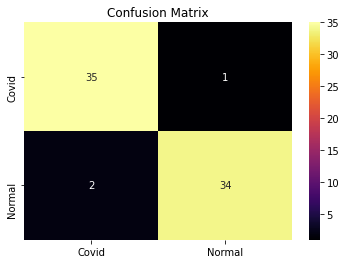

In [28]:
cm = confusion_matrix(y_actual, y_test)
target_names = {'Covid': 0, 'Normal': 1}

ax = plt.axes()
sns.heatmap(cm, 
            cmap="inferno", 
            annot=True, 
            fmt='g', 
            yticklabels=target_names, 
            xticklabels=target_names)
ax.set_title('Confusion Matrix')
plt.show()

In [29]:
print(classification_report(y_test, y_actual, target_names=target_names))
print("Precision score: {:.4f}".format(precision_score(y_actual, y_test)))
print("Recall score: {:.4f}".format(recall_score(y_actual, y_test)))
print("F1 Score: {:.4f}".format(f1_score(y_actual, y_test)))

              precision    recall  f1-score   support

       Covid       0.97      0.95      0.96        37
      Normal       0.94      0.97      0.96        35

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

Precision score: 0.9714
Recall score: 0.9444
F1 Score: 0.9577


<Figure size 432x288 with 0 Axes>

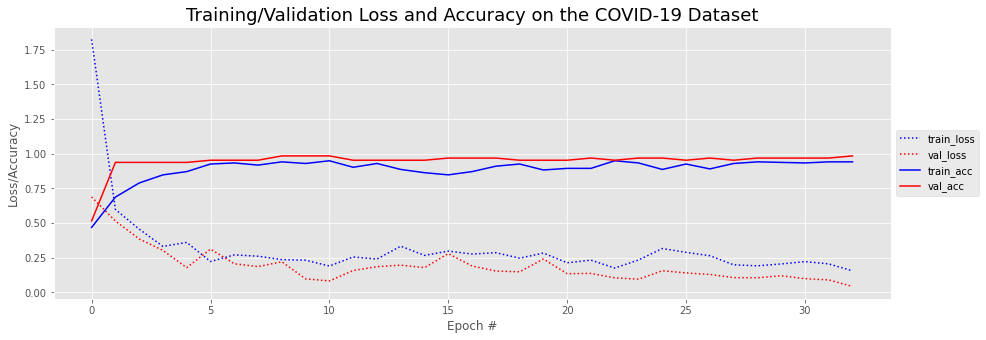

In [30]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss", color='blue', linestyle=':')
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss", color='red', linestyle=':')
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc", color='blue')
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc", color='red')
plt.title("Training/Validation Loss and Accuracy on the COVID-19 Dataset", fontsize=18)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':10})
plt.show()

In [31]:
model = load_model("covid19_model_adv.h5")
random_image = random.choice(os.listdir("./Covid_Dataset/Test/Covid/"))
img = image.load_img("./Covid_Dataset/Test/Covid/" + random_image, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
p = model.predict_classes(x)
print(random_image, p)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


covid-19-pneumonia-20.jpg [[0]]


**Conclusion**

The accuracy obtained was approximately 96%.